In [2]:
import sys
sys.path.insert(0, '../..')

# PARAMETERS
platesolve_file = "baseline_1_ps.csv"
sensor_file = "brennanhouse_test1_2023-02-03.txt"
sensor_timezone = -5  # GMT-5
sensor_date = "2023-02-03"

# Degrees
true_latitude = 37.23525053101054
true_longitude = -80.41863094

In [3]:
from astropy import units as u
from astropy.coordinates import Angle
from zenith_to_latlon_error import get_latlon
from multilateration import multilateration, angular_dist
import time
from dataclasses import dataclass
from typing import Tuple
from typing import List


@dataclass
class StarInfo:
    ra: Angle
    dec: Angle 
    alt: Angle
    time: Tuple[int]

    def zd(self): 
        return Angle('90d') - self.alt

    def latlon(self):
        return get_latlon(*self.time, self.ra, self.dec)


@dataclass
class MultilaterationResult:
    elapsed_time: float
    lat: Angle
    lon: Angle
    alt_bias: Angle
    err_angular: Angle
    err_nm: float

    def __str__(self):
        out = ""
        out += f"Elapsed: {self.elapsed_time}s\n"
        out += f"Latitude: {self.lat.to_string(unit=u.degree)}\n"
        out += f"Longitude: {self.lon.to_string(unit=u.degree)}\n"
        out += f"Alt. Bias: {self.alt_bias.to_string(unit=u.degree)}\n"
        out += f"Err. Angular Separation: {self.err_angular.to_string(unit=u.degree)} \n"
        out += f"Err. in NM: {self.err_nm}\n"
        return out


def run_multilateration(actual_latitude: Angle, actual_longitude: Angle, stardata: List[StarInfo]) -> MultilaterationResult:
    # radian vs radians below is because lat / lon coordinates are Skyfield Angles
    # whereas the zd coordiantes are astropy angles
    points = [([l.radians for l in p.latlon()], p.zd().radian) for p in stardata]

    before = time.time()
    result_lat_rads, result_lon_rads, result_alt_bias_rads = multilateration(points).x
    elapsed = time.time() - before

    result_lat = Angle(result_lat_rads, u.radian)
    result_lon = Angle(result_lon_rads, u.radian)
    result_alt_bias = Angle(result_alt_bias_rads, u.radian)

    error_angular = angular_dist((result_lat.radian, result_lon.radian), (actual_latitude.radian, actual_longitude.radian))
    error_angular = Angle(error_angular, u.radian)

    error_nm = error_angular.arcminute

    return MultilaterationResult(elapsed, result_lat, result_lon, result_alt_bias, error_angular, error_nm)

                        time       x        y        z
0    2023-02-04 01:41:04.128  1.3678  50.8832  39.0784
1    2023-02-04 01:41:04.413  1.3568  50.8997  39.0619
2    2023-02-04 01:41:04.663  1.3458  50.8832  39.0784
3    2023-02-04 01:41:04.914  1.3513  50.8722  39.0894
4    2023-02-04 01:41:05.148  1.3239  50.8777  39.0839
...                      ...     ...      ...      ...
1725 2023-02-04 01:48:31.835  6.6193  50.0757  39.1443
1726 2023-02-04 01:48:32.100  6.6193  50.0702  39.1498
1727 2023-02-04 01:48:32.366  6.5973  50.0977  39.1333
1728 2023-02-04 01:48:32.604  6.6302  50.0867  39.1278
1729 2023-02-04 01:48:32.854  6.6357  50.0592  39.1608

[1730 rows x 4 columns]


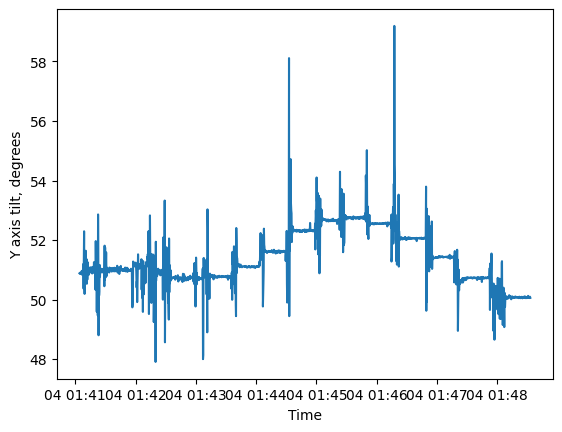

In [4]:

import pandas as pd
import re
from matplotlib import pyplot as plt


def parse_line(line: str, date: str) -> pd.Series:
    result = re.match(r"([0-9.:]+)\s*X Tilt: ([0-9]+\.[0-9]+).*Y Tilt: ([0-9]+\.[0-9]+).*Z Tilt: ([0-9]+\.[0-9]+)\s*", line)
    row = pd.Series({
        "time": pd.Timestamp(f"{date} {result.group(1)}") - pd.Timedelta(hours=sensor_timezone),
        "x": float(result.group(2)),
        "y": float(result.group(3)),
        "z": float(result.group(4))
    })
    return row


def read_sensor_txt(path: str, date: str) -> pd.DataFrame:
    with open(path) as file:
        df = pd.DataFrame(parse_line(line, date) for line in file.readlines())
    
    return df
        

data = read_sensor_txt(sensor_file, sensor_date)
print(data)

plt.figure()
plt.plot(data['time'], data['y'])
plt.ylabel("Y axis tilt, degrees")
plt.xlabel("Time")
plt.show()

In [5]:
def get_averaged_reading(reading_data: pd.DataFrame, col: str, exposure_start: pd.Timestamp, exposure_duration: pd.Timedelta) -> float:
    our_data = reading_data[reading_data['time'].between(exposure_start, exposure_start + exposure_duration)]
    plt.figure()
    plt.plot(our_data['time'],our_data[col])
    plt.ylabel(col)
    plt.xlabel('time')
    plt.show()
    return our_data[col].median()


def get_angle(reading_data: pd.DataFrame, exposure_start: pd.Timestamp, exposure_duration: pd.Timedelta) -> Angle:
    average = get_averaged_reading(reading_data, 'y', exposure_start, exposure_duration)
    return Angle(average, unit=u.deg)



            ra        dec      date     time
0   130.035221  45.180186  2/4/2023  1:41:43
1   123.150021  25.713784  2/4/2023  1:42:47
2   111.054148  10.781577  2/4/2023  1:43:26
3    94.737776   1.256298  2/4/2023  1:43:53
4    77.467390  -1.005296  2/4/2023  1:44:20
5    58.898321   4.631791  2/4/2023  1:44:48
6    44.624796  16.180594  2/4/2023  1:45:15
7    33.994684  33.049577  2/4/2023  1:45:40
8    30.029581  50.580645  2/4/2023  1:46:05
9    42.908919  69.541131  2/4/2023  1:46:34
10   97.867634  74.783536  2/4/2023  1:47:08
11  129.431186  62.902944  2/4/2023  1:47:35
12  131.483900  38.733204  2/4/2023  1:48:20


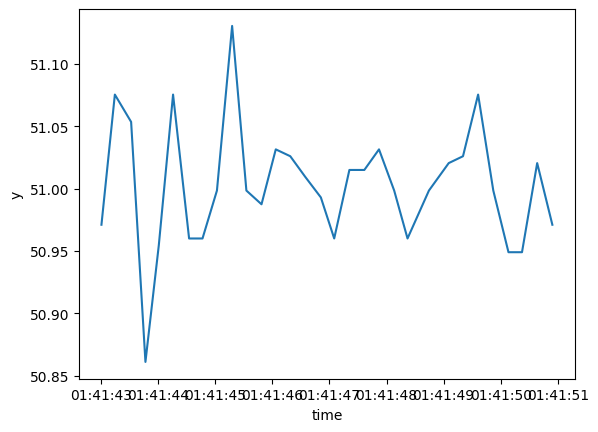

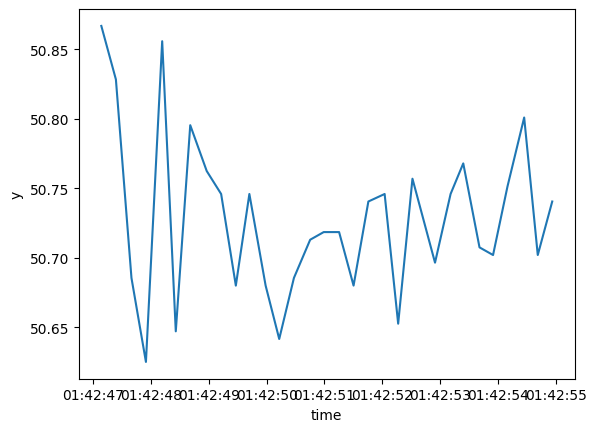

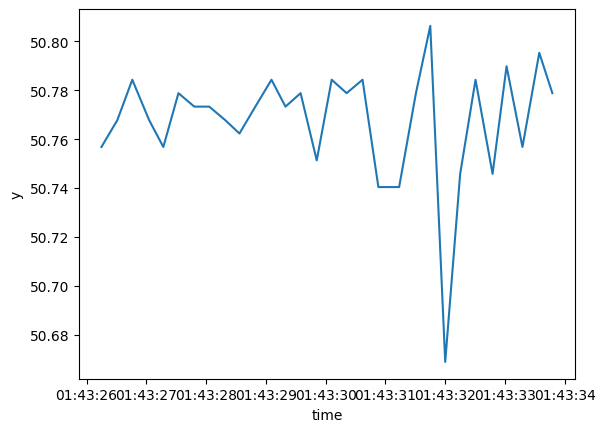

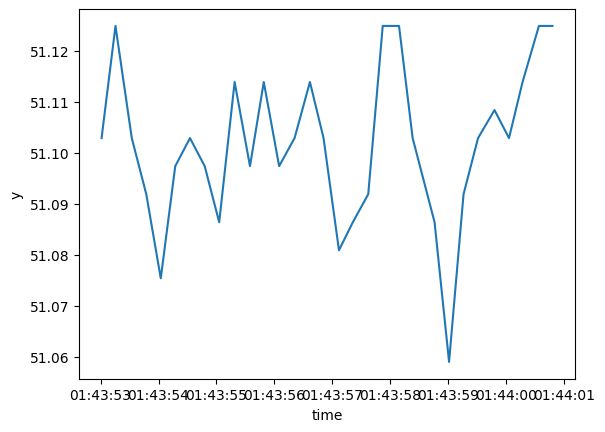

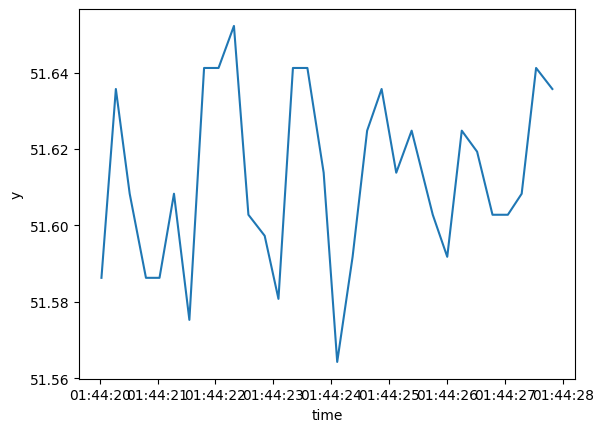

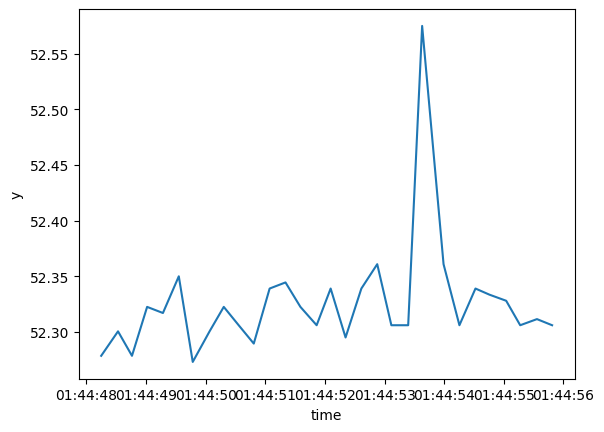

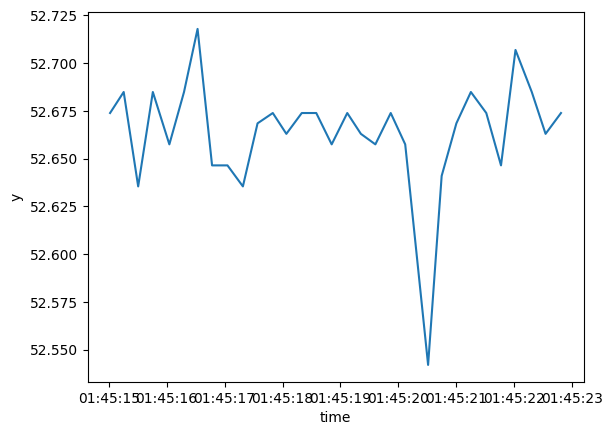

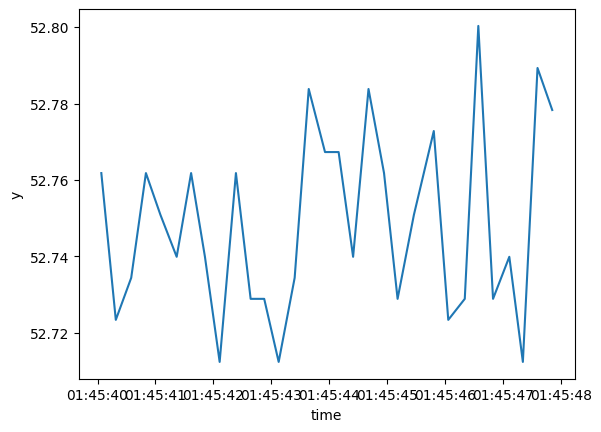

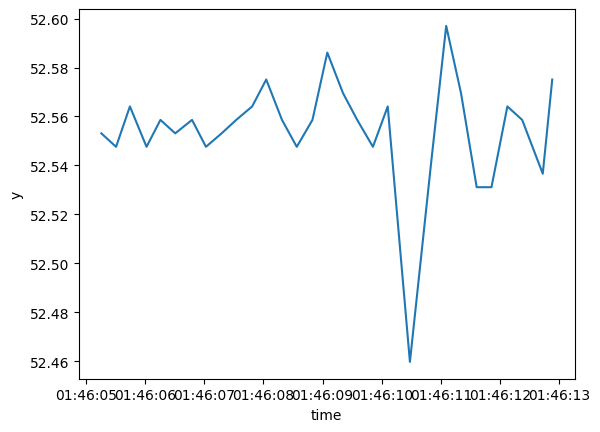

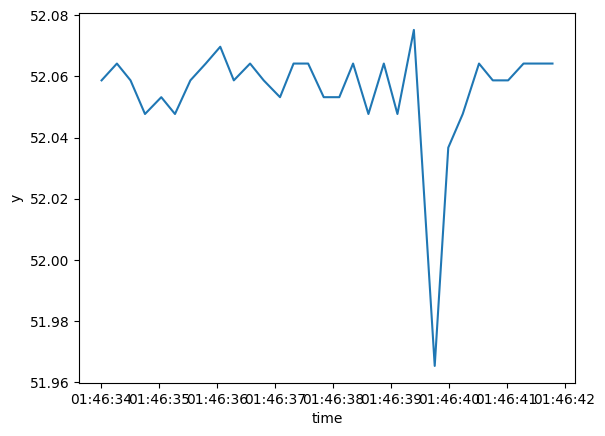

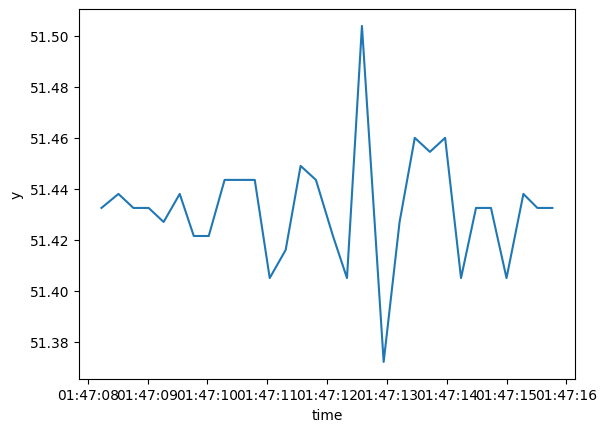

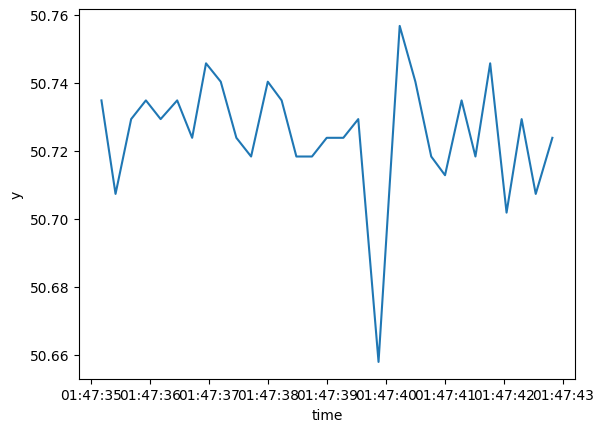

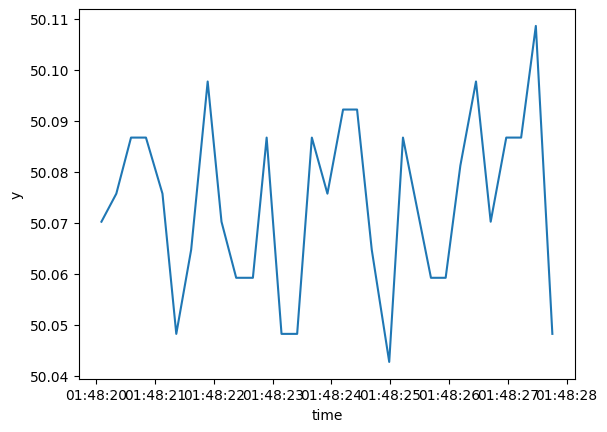

[StarInfo(ra=<Angle 130.0352211 deg>, dec=<Angle 45.18018641 deg>, alt=<Angle 50.9985 deg>, time=(2023, 2, 4, 1, 41, 43)),
 StarInfo(ra=<Angle 123.1500213 deg>, dec=<Angle 25.71378355 deg>, alt=<Angle 50.7184 deg>, time=(2023, 2, 4, 1, 42, 47)),
 StarInfo(ra=<Angle 111.0541484 deg>, dec=<Angle 10.78157744 deg>, alt=<Angle 50.7733 deg>, time=(2023, 2, 4, 1, 43, 26)),
 StarInfo(ra=<Angle 94.73777551 deg>, dec=<Angle 1.25629792 deg>, alt=<Angle 51.1029 deg>, time=(2023, 2, 4, 1, 43, 53)),
 StarInfo(ra=<Angle 77.46738994 deg>, dec=<Angle -1.00529603 deg>, alt=<Angle 51.6083 deg>, time=(2023, 2, 4, 1, 44, 20)),
 StarInfo(ra=<Angle 58.89832102 deg>, dec=<Angle 4.631791 deg>, alt=<Angle 52.31415 deg>, time=(2023, 2, 4, 1, 44, 48)),
 StarInfo(ra=<Angle 44.62479553 deg>, dec=<Angle 16.18059397 deg>, alt=<Angle 52.6685 deg>, time=(2023, 2, 4, 1, 45, 15)),
 StarInfo(ra=<Angle 33.99468359 deg>, dec=<Angle 33.04957731 deg>, alt=<Angle 52.7399 deg>, time=(2023, 2, 4, 1, 45, 40)),
 StarInfo(ra=<Angle

In [6]:
import pandas as pd

duration = pd.Timedelta(seconds=8)
ps_data = pd.read_csv(platesolve_file)
print(ps_data)

def get_date_tuple(datestr, timestr):
    month, day, year = [int(x) for x in datestr.split('/')]
    hour, min, sec = [int(x) for x in timestr.split(':')]
    return (year, month, day, hour, min, sec)

# Note we are GMT-5, so must correct in `time=`
real_stardata = [StarInfo(
    ra=Angle(ra, unit=u.degree),
    dec=Angle(dec, unit=u.degree),
    alt=get_angle(
        data,
        pd.Timestamp(f"{date} {time}"),
        duration
    ),
    time=get_date_tuple(date,time)
) for ra,dec,date,time in zip(ps_data['ra'], ps_data['dec'], ps_data['date'], ps_data['time'])]
real_stardata

In [7]:
result = run_multilateration(
    Angle(true_latitude, unit=u.degree), 
    Angle(true_longitude, unit=u.degree), 
    # [real_stardata[1], real_stardata[6], real_stardata[9]]
    real_stardata
)
print(str(result))

print("RESULT:")
print(result.lat.deg)
print(result.lon.deg)

print("ACTUAL:")
print(Angle(true_latitude, unit=u.degree).deg)
print(Angle(true_longitude, unit=u.degree).deg)

Elapsed: 0.010237455368041992s
Latitude: 37d17m09.55424169s
Longitude: -80d27m03.35452032s
Alt. Bias: -0d06m18.41117344s
Err. Angular Separation: 0d03m24.76110117s 
Err. in NM: 3.4126850194609433

RESULT:
37.2859872893573
-80.45093181120075
ACTUAL:
37.23525053101054
-80.41863094


In [13]:
def calculate_result_wo_outliers(stardata, m=2):
    import numpy as np
    data = np.array([])

    # runs each multilateration subtracting one picture's dataset each
    for i in range(0, len(stardata)):
        result = run_multilateration(
            Angle(true_latitude, unit=u.degree), 
            Angle(true_longitude, unit=u.degree), 
            [stardata[j] for j in range(len(stardata)) if j not in [i]]
        )
        data = np.append(data, result.alt_bias.degree)
        
    # calculates the outlires based on the median of the datasets
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zero(len(d))
    nonoutliers = np.asarray(s<m).nonzero()

    # runs the final multilateration removing calculated outliers
    final_result = result = run_multilateration(
        Angle(true_latitude, unit=u.degree), 
        Angle(true_longitude, unit=u.degree), 
        [stardata[k] for k in range(len(stardata)) if np.isin(k, nonoutliers)]
    )

    return data, final_result

[data, result] = calculate_result_wo_outliers(real_stardata, 2)
plot(data)

Elapsed: 0.005748271942138672s
Latitude: 37d17m13.96775324s
Longitude: -80d26m58.12112516s
Alt. Bias: -0d05m54.06367578s
Err. Angular Separation: 0d03m26.89397819s 
Err. in NM: 3.448232969792019

